In [1]:
begin
    using CairoMakie
    using DelimitedFiles
    using HDF5
    using ImageSegmentation
    using JuMP
    using LaTeXStrings
    using LinearAlgebra
    using NLopt
    using Rotations
    using Statistics
    print(Threads.nthreads())
end;

12

In [2]:
begin
	# 172 μm x 487 pixels (W) x 172μm x 619 pixels (H), 83.8 mm x106.5mm (W x H)
    # unit: mm
    struct Parameters
        Exp_SourceXYZ::Array{Float64,1}
        Exp_DetectorCenterXYZ::Array{Float64,1}
        Exp_PixelSize::Array{Float64,1}
        Exp_PixelNums::Array{Int32,1}
		Exp_DetectorSize::Array{Float64,1}
        Exp_EnergyLims::Array{Float64,1}
        Mat_CrystalType::String
        Mat_LatticePara::Array{Float64,1}
        GrainEuler::Array{Float64,1} # [θ ψ φ; ...]
        GrainCenter::Array{Float64,1} # [x y z; ...]
		Outputdir::String
    end
    include("function.jl")
    Para = Parameters(
        [0., -70., 0.], # Exp_SourceXYZ
        [(244-239.18)*0.172, 56.15, (339.5-310)*0.172], # Exp_DetectorCenterXYZ
        [0.172, 0.172], # Exp_PixelSize
        [487, 619], # Exp_PixelNums
		[83.764, 106.468], # Exp_DetectorSize
        [4., 70.], #[4.5, 70.], # Exp_EnergyLims
        "Silicon", # Mat_CrystalType
        [543.1e-9, 543.1e-9, 543.1e-9], # Mat_LatticePara
        [-88., 44., 87.], # GrainEuler in deg 
        [0., 0., 0.], # GrainCenter
		"Silicon"
        )
	isdir(Para.Outputdir) || mkdir(Para.Outputdir)
    CreateHKLF2ListFile(Para, 30)
end;

"We have 872 hkls!"

"We have 92 spots"

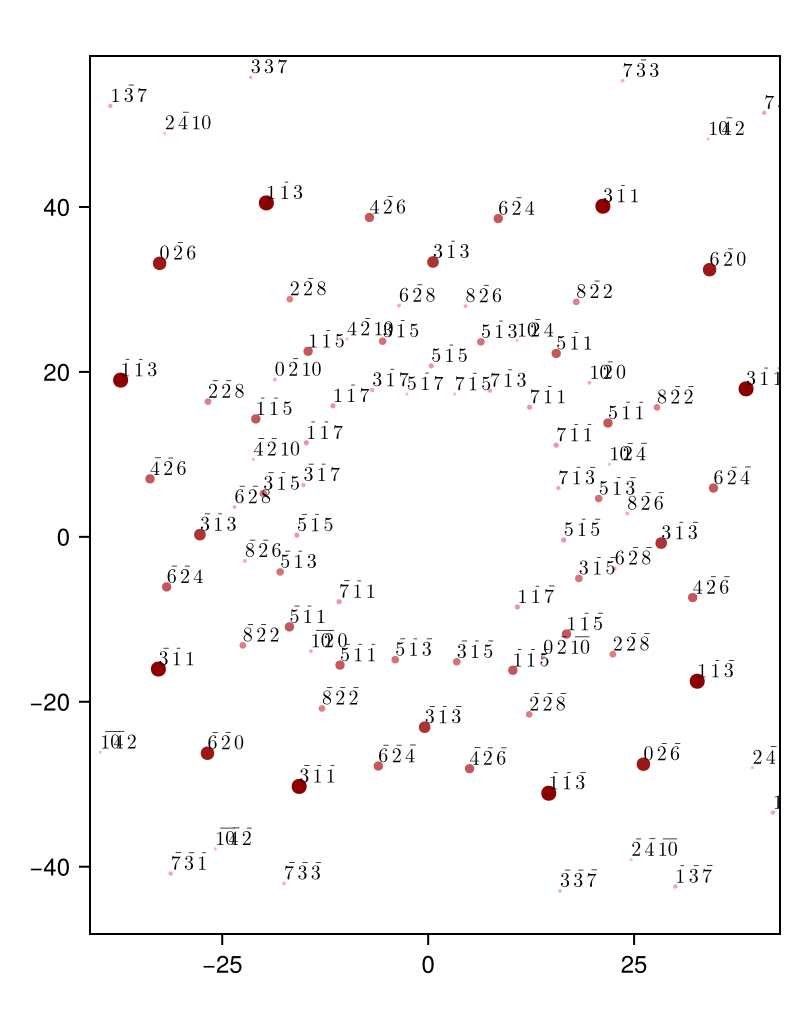

In [3]:
let
	BaseHKLs = read(h5open(Para.Outputdir*"/BaseHKLF2.h5", "r")["HKL"])
	BaseF2s = read(h5open(Para.Outputdir*"/BaseHKLF2.h5", "r")["F2"])
	HKL, Inten, DiffVect, DiffBeam, LaueXYZ, d_spacing, E = SimulateLaueSpotListCubic(Para, BaseHKLs, BaseF2s)
	if size(LaueXYZ,1)>0
		fig = Figure(; size = (Para.Exp_PixelNums[1]/1.2, Para.Exp_PixelNums[2]/1.2), fontsize = 12)
		ax = Axis(fig[1, 1], aspect = DataAspect(), xgridvisible = false, ygridvisible = false)
		scatter!(LaueXYZ[:,1], LaueXYZ[:,3], markersize = Inten./200, color = Inten, colormap = (:reds), strokecolor = :black, strokewidth = 0)
		display("We have "*string(size(HKL,1))*" spots")
		for i in 1:size(HKL,1)
			hh, kk, ll = HKL[i,1], HKL[i,2], HKL[i,3]
			if hh<0
				hh = string(-hh)
				text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\overline{%$hh}", fontsize=10)
			else
				text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"%$hh", fontsize=10)
			end
			if kk<0
				kk = string(-kk)
				text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{  }\overline{%$kk}", fontsize=10)
			else
				text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{  }%$kk", fontsize=10)
			end
			if ll<0
				ll = string(-ll)
				text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{    }\overline{%$ll}", fontsize=10)
			else
				text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{    }%$ll", fontsize=10)
			end
		end
		xlims!(ax, Para.Exp_DetectorCenterXYZ[1]-Para.Exp_DetectorSize[1]/2, Para.Exp_DetectorCenterXYZ[1]+Para.Exp_DetectorSize[1]/2)
		ylims!(ax, Para.Exp_DetectorCenterXYZ[3]-Para.Exp_DetectorSize[2]/2, Para.Exp_DetectorCenterXYZ[3]+Para.Exp_DetectorSize[2]/2)
		current_figure()
	end
end

In [4]:
let # EulerSpace base data (time-consuming)
	BaseHKLs = read(h5open(Para.Outputdir*"/BaseHKLF2.h5", "r")["HKL"])
	BaseF2s = read(h5open(Para.Outputdir*"/BaseHKLF2.h5", "r")["F2"])
	EulerSpace = readdlm("PreData/OriSpace_cubic_1deg.txt", Float32)
    nEuler = size(EulerSpace,1)
	HKLRef = zeros(Int8, 200, 3, nEuler)
	IntenRef = zeros(Float32, 200, nEuler)
	PeakNum = zeros(Int32, nEuler)
	LaueXYZRef = zeros(Float32, 200, 3, nEuler)
	maxline = 0
	for iEuler in 1:nEuler #Threads.@threads
		Para.GrainEuler[1] = EulerSpace[iEuler,1]
		Para.GrainEuler[2] = EulerSpace[iEuler,2]
		Para.GrainEuler[3] = EulerSpace[iEuler,3]
		HKL, Inten, DiffVect, DiffBeam, LaueXYZ, d_spacing, E = SimulateLaueSpotListCubic(Para, BaseHKLs, BaseF2s)
		PeakNum[iEuler] = size(LaueXYZ,1)
		if PeakNum[iEuler]>0
			HKLRef[1:PeakNum[iEuler],:,iEuler] = HKL
			IntenRef[1:PeakNum[iEuler],iEuler] = Inten
			LaueXYZRef[1:PeakNum[iEuler],:,iEuler] = LaueXYZ
			maxline = maximum([size(LaueXYZ,1), maxline])
		end
	end
	FileName = Para.Outputdir*"/1-BackwardCal_Ref_Global.h5"
    if isfile(FileName); rm(FileName); end
    fid = h5open(FileName, "w")
		fid["Euler"] = EulerSpace
        fid["HKLRef"] = Int8.(HKLRef[1:maxline,:,:])
		fid["IntenRef"] = Float32.(IntenRef[1:maxline,:])
        fid["LaueXYZRef"] = Float32.(LaueXYZRef[1:maxline,:,:])
		fid["PeakNum"] = Int32.(PeakNum)
    close(fid)
end;

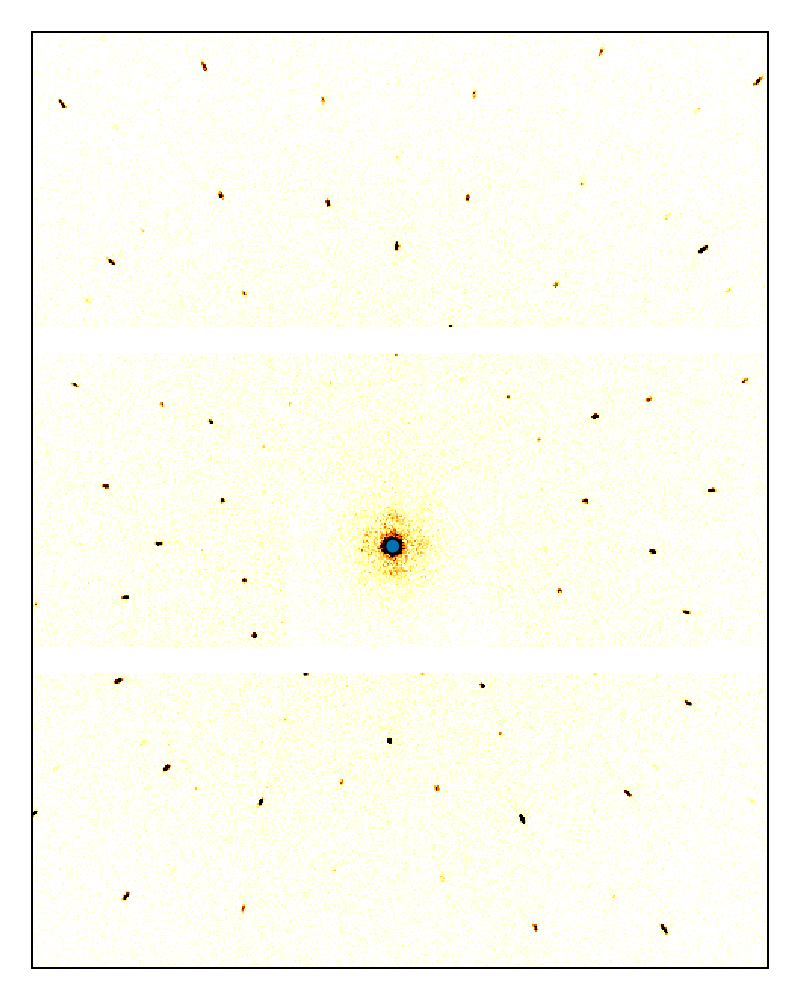

In [26]:
let # exp tiff polishing
    using TiffImages
    img = Float32.(TiffImages.load(Para.Outputdir*"/Si_ET20keV_Zd50_10s_.tif"))*2^31
    begin
        fig = Figure(; size = (400, 500), fontsize = 16)
        ax = Axis(fig[1, 1], aspect = DataAspect())
        #img[img.<15].=0
        #img[320:360, 220:260].=0
        heatmap!(img'[:,end:-1:1], colormap = Reverse(:afmhot), colorrange = (0, 20))
        scatter!(239.18, 619-339.5)
        hidedecorations!(ax)  # hides ticks, grid and lables
        current_figure()
    end
end

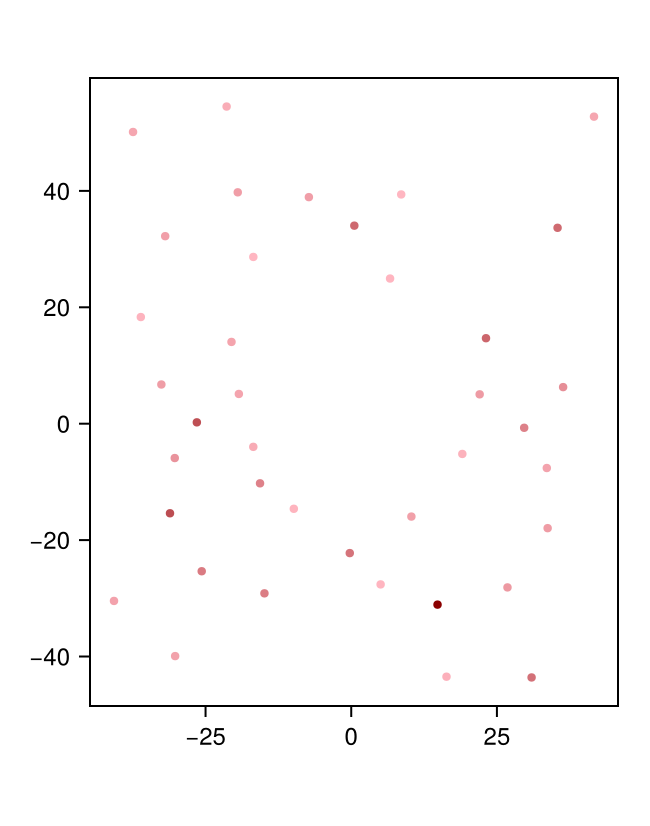

In [5]:
let # processing tiff
    using TiffImages
    imgRaw = Float32.(TiffImages.load(Para.Outputdir*"/Si_ET20keV_Zd50_10s_.tif"))*2^31
    imgRaw = imgRaw'
    imgRaw = imgRaw[:,end:-1:1]
    img = copy(imgRaw)
    img[img.<15].=0
    img[220:260, 260:300].=0
    begin # segmentation
        img[img.>0] .= 1
        img = Int8.(img)
        seg = fast_scanning(img, 0.5)
        seg_pixels = zeros(Int64, length(segment_labels(seg)), 2)
        for i in 1:length(segment_labels(seg))
            seg_pixels[i,:] = [segment_labels(seg)[i] segment_pixel_count(seg, segment_labels(seg)[i])]
        end
        seg_pixels = seg_pixels[sortperm(seg_pixels[:,2])[1:end-1],:]
        seg_pixels = seg_pixels[seg_pixels[:,2].>1,:]
        outfilename = Para.Outputdir*"/Exp_segmentation.h5"
        ~isfile(outfilename) || rm(outfilename)
        h5write(outfilename, "labels_map", Int32.(labels_map(seg)))
        h5write(outfilename, "seg_pixels", seg_pixels)
    end
    begin # peak data
        n = size(seg_pixels,1)
        xzIntensity = zeros(Float32, n, 3)
        for i in 1:n #Threads.@threads
            p = findall(x->x==seg_pixels[i,1], labels_map(seg))
            xyI = zeros(length(p), 3)
            for j in 1:length(p)
                xyI[j,:] = [p[j][1]  p[j][2]  imgRaw[Int32(p[j][1]), Int32(p[j][2])]]
            end
            xzIntensity[i,:] = [sum(xyI[:,1].*xyI[:,3])/sum(xyI[:,3]) sum(xyI[:,2].*xyI[:,3])/sum(xyI[:,3]) sum(xyI[:,3])]
        end
    end
    open(Para.Outputdir*"/Exp_LaueXYZ_Intensity.txt"; write=true) do io
        for i in 1:size(xzIntensity,1)
            x = xzIntensity[i,1]*Para.Exp_PixelSize[1]-(Para.Exp_DetectorSize[1]/2-Para.Exp_DetectorCenterXYZ[1])
            y = Para.Exp_DetectorCenterXYZ[2]
            z = xzIntensity[i,2]*Para.Exp_PixelSize[2]-(Para.Exp_DetectorSize[2]/2-Para.Exp_DetectorCenterXYZ[3])
            write(io, @sprintf("%12.6f %12.6f %12.6f   %12i\n",  x, y, z, xzIntensity[i,3]))
        end
    end
    # [(244-239.18)*0.172, 56.15, (339.5-310)*0.172], # Exp_DetectorCenterXYZ
    begin
        fig = Figure(; size = (Para.Exp_PixelNums[1]/1.5, Para.Exp_PixelNums[2]/1.5), fontsize = 12)
        ax = Axis(fig[1, 1], aspect = DataAspect(), xgridvisible = false, ygridvisible = false)
		LaueXYZInten = Float32.(readdlm(Para.Outputdir*"/Exp_LaueXYZ_Intensity.txt"))
		scatter!(LaueXYZInten[:,1], LaueXYZInten[:,3], markersize = 6, color = LaueXYZInten[:,4], colormap = (:reds), strokecolor = :black, strokewidth = 0)
		#xlims!(ax, Para.Exp_DetectorCenterXYZ[1]-Para.Exp_DetectorSize[1]/2, Para.Exp_DetectorCenterXYZ[1]+Para.Exp_DetectorSize[1]/2)
		#ylims!(ax, Para.Exp_DetectorCenterXYZ[3]-Para.Exp_DetectorSize[2]/2, Para.Exp_DetectorCenterXYZ[3]+Para.Exp_DetectorSize[2]/2)
        current_figure()
    end
end

In [5]:
let # find the best fitted Eulers from the EulerSpace
    fid = h5open(Para.Outputdir*"/1-BackwardCal_Ref_Global.h5", "r")
        HKLRef, LaueXYZRef = read(fid["HKLRef"]), read(fid["LaueXYZRef"])
    close(fid)
    LaueXYZ = Float32.(readdlm(Para.Outputdir*"/Exp_LaueXYZ_Intensity.txt")[:,1:3])
    MaxFitDistance = 3.
    BestNToBeAveraged = 20
    OutputFileName = Para.Outputdir*"/2-BackwardCal_Ref_Distance_Badness_MatchedN.h5"
    CalculateGlobalDistance!(
        Para::Parameters,
        LaueXYZ::Union{Array{Float32, 2},Array{Float64,2}},
        LaueXYZRef::Union{Array{Float32,3},Array{Float64,3}},
        MaxFitDistance::Union{Float32,Float64},
        BestNToBeAveraged::Union{Int8,Int32,Int64},
        OutputFileName::String
        )
end;

0.5443636f0

1×3 adjoint(::Vector{Float32}) with eltype Float32:
 -88.5916  44.4794  87.4639

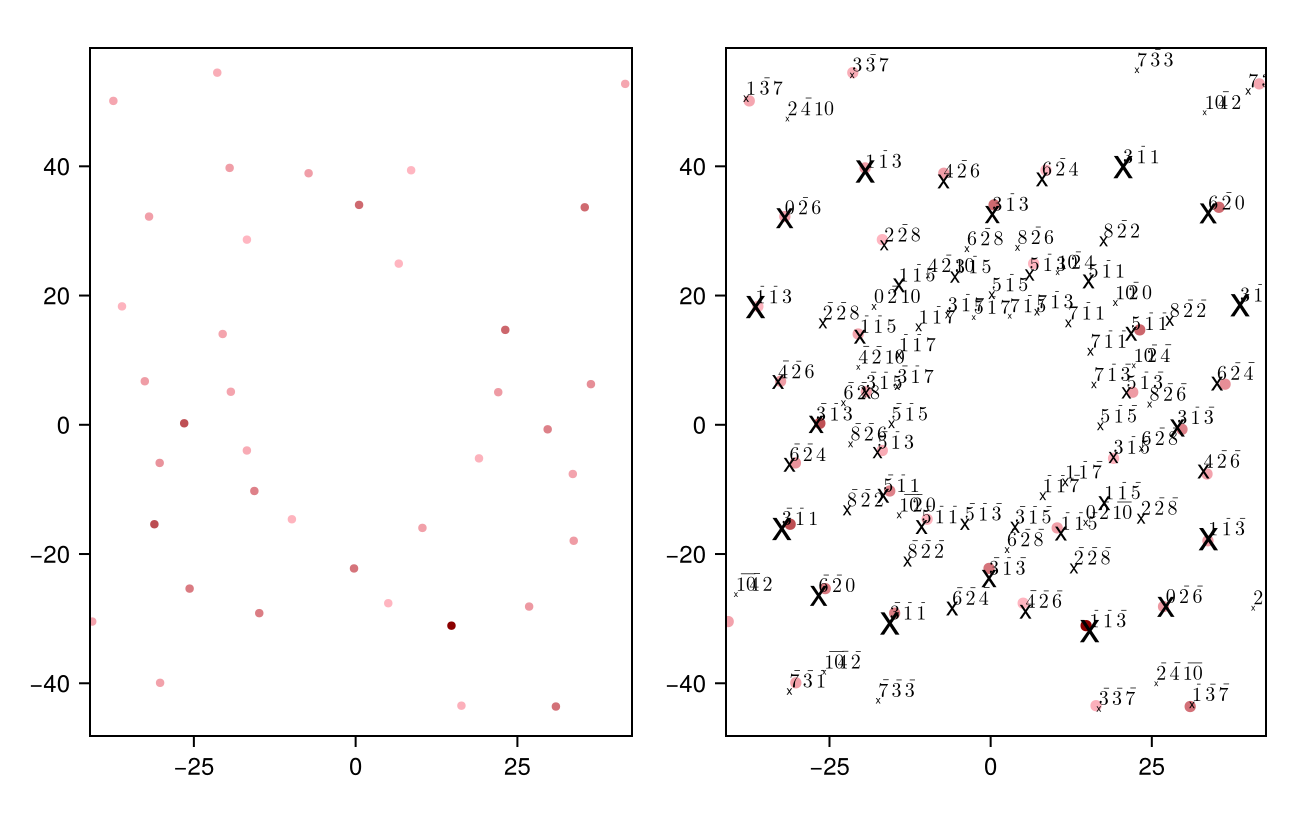

In [10]:
let
	fig = Figure(; size = (2Para.Exp_PixelNums[1]/1.5, Para.Exp_PixelNums[2]/1.5), fontsize = 12)
    begin
        ax = Axis(fig[1, 1], aspect = DataAspect(), xgridvisible = false, ygridvisible = false)
        scatter!(239.18, 619-339.5)
		LaueXYZInten = Float32.(readdlm(Para.Outputdir*"/Exp_LaueXYZ_Intensity.txt"))
		scatter!(LaueXYZInten[:,1], LaueXYZInten[:,3], markersize = 6, color = LaueXYZInten[:,4], colormap = (:reds), strokecolor = :black, strokewidth = 0)
		xlims!(ax, Para.Exp_DetectorCenterXYZ[1]-Para.Exp_DetectorSize[1]/2, Para.Exp_DetectorCenterXYZ[1]+Para.Exp_DetectorSize[1]/2)
		ylims!(ax, Para.Exp_DetectorCenterXYZ[3]-Para.Exp_DetectorSize[2]/2, Para.Exp_DetectorCenterXYZ[3]+Para.Exp_DetectorSize[2]/2)
    end
	EulerSpace = read(h5open(Para.Outputdir*"/1-BackwardCal_Ref_Global.h5"))["Euler"]
	Badness = read(h5open(Para.Outputdir*"/2-BackwardCal_Ref_Distance_Badness_MatchedN.h5"))["Badness"]
	iEuler = argmin(Badness)
	display(minimum(Badness))
	display(EulerSpace[iEuler,:]')
	Para.GrainEuler[1] = EulerSpace[iEuler,1]
	Para.GrainEuler[2] = EulerSpace[iEuler,2]
	Para.GrainEuler[3] = EulerSpace[iEuler,3]
	BaseHKLs = read(h5open(Para.Outputdir*"/BaseHKLF2.h5", "r")["HKL"])
	BaseF2s = read(h5open(Para.Outputdir*"/BaseHKLF2.h5", "r")["F2"])
	HKL, Inten, DiffVect, DiffBeam, LaueXYZ, d_spacing, E = SimulateLaueSpotListCubic(Para, BaseHKLs, BaseF2s)
	if size(LaueXYZ,1)>0
		ax = Axis(fig[1, 2], aspect = DataAspect(), xgridvisible = false, ygridvisible = false)
		begin
			LaueXYZInten = Float32.(readdlm(Para.Outputdir*"/Exp_LaueXYZ_Intensity.txt"))
			scatter!(LaueXYZInten[:,1], LaueXYZInten[:,3], markersize = 8, color = LaueXYZInten[:,4], colormap = (:reds), strokecolor = :black, strokewidth = 0)
		end
		scatter!(LaueXYZ[:,1], LaueXYZ[:,3], marker = 'x', markersize = Inten./100, color = :black)
		LabelIt = true
		for i in 1:size(HKL,1)
			hh, kk, ll = HKL[i,1], HKL[i,2], HKL[i,3]
			if LabelIt
				if hh<0
					hh = abs(hh)
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\overline{%$hh}", fontsize=10)
				else
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"%$hh", fontsize=10)
				end
				if kk<0
					kk = abs(kk)
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{  }\overline{%$kk}", fontsize=10)
				else
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{  }%$kk", fontsize=10)
				end
				if ll<0
					ll = abs(ll)
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{    }\overline{%$ll}", fontsize=10)
				else
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{    }%$ll", fontsize=10)
				end
			end
		end
		xlims!(ax, Para.Exp_DetectorCenterXYZ[1]-Para.Exp_DetectorSize[1]/2, Para.Exp_DetectorCenterXYZ[1]+Para.Exp_DetectorSize[1]/2)
		ylims!(ax, Para.Exp_DetectorCenterXYZ[3]-Para.Exp_DetectorSize[2]/2, Para.Exp_DetectorCenterXYZ[3]+Para.Exp_DetectorSize[2]/2)
	end
	current_figure()
end

In [4]:
let # find the best fitted Eulers from the LocalEulerSpace
	EulerSpace = read(h5open(Para.Outputdir*"/1-BackwardCal_Ref_Global.h5"))["Euler"]
	iEuler = argmin(read(h5open(Para.Outputdir*"/2-BackwardCal_Ref_Distance_Badness_MatchedN.h5"))["Badness"])
    BaseHKLs = read(h5open(Para.Outputdir*"/BaseHKLF2.h5", "r")["HKL"])
	BaseF2s = read(h5open(Para.Outputdir*"/BaseHKLF2.h5", "r")["F2"])
    # local EulerSpace base data
    EulerSpaceLocal = zeros(Float32, 21^3, 3)
    PeakNum = zeros(Int8, 21^3)
    HKLRef = zeros(Int8, 200, 3, 21^3)
    IntenRef = zeros(Float32, 200, 21^3)
    LaueXYZRef = zeros(Float32, 200, 3, 21^3)
    maxline = 0
    ijk = 0
    for i in -10:10, j in -10:10, k in -10:10
        Para.GrainEuler[1] = EulerSpace[iEuler,1]+0.1i
        Para.GrainEuler[2] = EulerSpace[iEuler,2]+0.1j
        Para.GrainEuler[3] = EulerSpace[iEuler,3]+0.1k
        HKL, Inten, DiffVect, DiffBeam, LaueXYZ, d_spacing, E = SimulateLaueSpotListCubic(Para, BaseHKLs, BaseF2s)
        ijk = ijk+1
        EulerSpaceLocal[ijk,:] = [Para.GrainEuler[1] Para.GrainEuler[2] Para.GrainEuler[3]]
        PeakNum[ijk] = size(HKL,1)
        HKLRef[1:PeakNum[ijk],:,ijk] = HKL
        IntenRef[1:PeakNum[ijk],ijk] = Inten
        LaueXYZRef[1:PeakNum[ijk],:,ijk] = LaueXYZ
        maxline = maximum([PeakNum[ijk], maxline])
    end
    FileName = Para.Outputdir*"/3-BackwardCal_Ref_Local.h5"
    if isfile(FileName); rm(FileName); end
    fid = h5open(FileName, "w")
        fid["Euler"] = Float32.(EulerSpaceLocal)
        fid["HKLRef"] = Int8.(HKLRef[1:maxline,:,:])
        fid["IntenRef"] = Float32.(IntenRef[1:maxline,:])
        fid["LaueXYZRef"] = Float32.(LaueXYZRef[1:maxline,:,:])
        fid["PeakNum"] = Int8.(PeakNum)
    close(fid)
    LaueXYZ = Float32.(readdlm(Para.Outputdir*"/Exp_LaueXYZ_Intensity.txt")[:,1:3])
	MaxFitDistance = 3.
    MatchedN = read(h5open(Para.Outputdir*"/2-BackwardCal_Ref_Distance_Badness_MatchedN.h5"))["MatchedN"]
    BestNToBeAveraged = MatchedN[argmin(read(h5open(Para.Outputdir*"/2-BackwardCal_Ref_Distance_Badness_MatchedN.h5"))["Badness"])]
    OutputFileName = Para.Outputdir*"/4-BackwardCal_Ref_Distance_Badness_MatchedN.h5"
    CalculateGlobalDistance!(
        Para::Parameters,
        LaueXYZ::Union{Array{Float32, 2},Array{Float64,2}},
        LaueXYZRef::Union{Array{Float32,3},Array{Float64,3}},
        MaxFitDistance::Union{Float32,Float64},
        BestNToBeAveraged::Union{Int8,Int32,Int64},
        OutputFileName::String
        )
    iEuler = argmin(read(h5open(Para.Outputdir*"/4-BackwardCal_Ref_Distance_Badness_MatchedN.h5"))["Badness"])
    display(EulerSpaceLocal[iEuler,:]')
end;

1×3 adjoint(::Vector{Float32}) with eltype Float32:
 -88.3916  44.1794  86.7639

0.2952551f0

0.2952551f0

1×3 adjoint(::Vector{Float32}) with eltype Float32:
 -88.3916  44.1794  86.7639

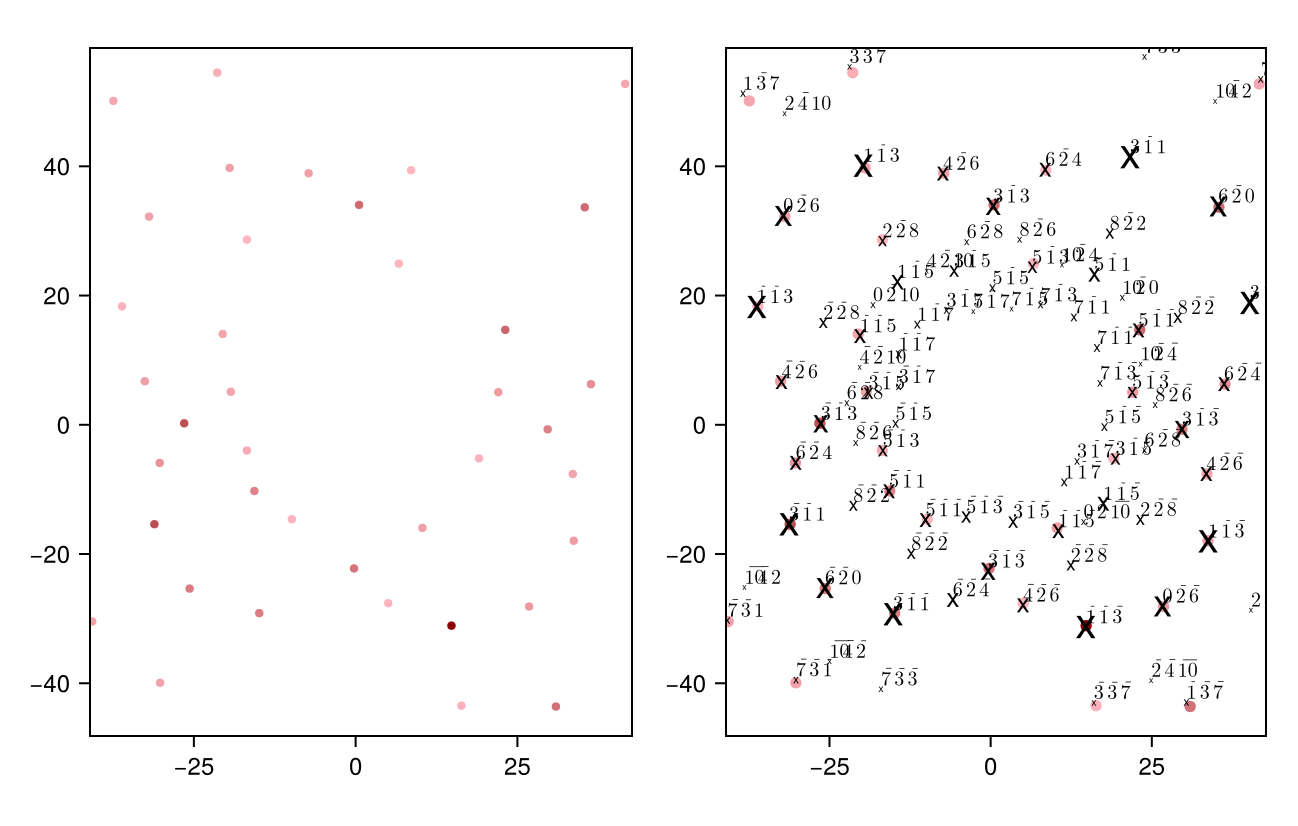

In [9]:
let
	fig = Figure(; size = (2Para.Exp_PixelNums[1]/1.5, Para.Exp_PixelNums[2]/1.5), fontsize = 12)
    begin
        ax = Axis(fig[1, 1], aspect = DataAspect(), xgridvisible = false, ygridvisible = false)
        scatter!(239.18, 619-339.5)
		LaueXYZInten = Float32.(readdlm(Para.Outputdir*"/Exp_LaueXYZ_Intensity.txt"))
		scatter!(LaueXYZInten[:,1], LaueXYZInten[:,3], markersize = 6, color = LaueXYZInten[:,4], colormap = (:reds), strokecolor = :black, strokewidth = 0)
		xlims!(ax, Para.Exp_DetectorCenterXYZ[1]-Para.Exp_DetectorSize[1]/2, Para.Exp_DetectorCenterXYZ[1]+Para.Exp_DetectorSize[1]/2)
		ylims!(ax, Para.Exp_DetectorCenterXYZ[3]-Para.Exp_DetectorSize[2]/2, Para.Exp_DetectorCenterXYZ[3]+Para.Exp_DetectorSize[2]/2)
    end
	EulerSpace = read(h5open(Para.Outputdir*"/3-BackwardCal_Ref_Local.h5"))["Euler"]
	Badness = read(h5open(Para.Outputdir*"/4-BackwardCal_Ref_Distance_Badness_MatchedN.h5"))["Badness"]
    display(minimum(Badness))
    iEuler = argmin(Badness)
    display(EulerSpace[iEuler,:]')
	Para.GrainEuler[1] = EulerSpace[iEuler,1]
	Para.GrainEuler[2] = EulerSpace[iEuler,2]
	Para.GrainEuler[3] = EulerSpace[iEuler,3]
	BaseHKLs = read(h5open(Para.Outputdir*"/BaseHKLF2.h5", "r")["HKL"])
	BaseF2s = read(h5open(Para.Outputdir*"/BaseHKLF2.h5", "r")["F2"])
	HKL, Inten, DiffVect, DiffBeam, LaueXYZ, d_spacing, E = SimulateLaueSpotListCubic(Para, BaseHKLs, BaseF2s)
	if size(LaueXYZ,1)>0
		ax = Axis(fig[1, 2], aspect = DataAspect(), xgridvisible = false, ygridvisible = false)
		begin
			LaueXYZInten = Float32.(readdlm(Para.Outputdir*"/Exp_LaueXYZ_Intensity.txt"))
			scatter!(LaueXYZInten[:,1], LaueXYZInten[:,3], markersize = 8, color = LaueXYZInten[:,4], colormap = (:reds), strokecolor = :black, strokewidth = 0)
		end
		scatter!(LaueXYZ[:,1], LaueXYZ[:,3], marker = 'x', markersize = Inten./100, color = :black)
		LabelIt = true
		for i in 1:size(HKL,1)
			hh, kk, ll = HKL[i,1], HKL[i,2], HKL[i,3]
			if LabelIt
				if hh<0
					hh = abs(hh)
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\overline{%$hh}", fontsize=10)
				else
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"%$hh", fontsize=10)
				end
				if kk<0
					kk = abs(kk)
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{  }\overline{%$kk}", fontsize=10)
				else
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{  }%$kk", fontsize=10)
				end
				if ll<0
					ll = abs(ll)
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{    }\overline{%$ll}", fontsize=10)
				else
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{    }%$ll", fontsize=10)
				end
			end
		end
		xlims!(ax, Para.Exp_DetectorCenterXYZ[1]-Para.Exp_DetectorSize[1]/2, Para.Exp_DetectorCenterXYZ[1]+Para.Exp_DetectorSize[1]/2)
		ylims!(ax, Para.Exp_DetectorCenterXYZ[3]-Para.Exp_DetectorSize[2]/2, Para.Exp_DetectorCenterXYZ[3]+Para.Exp_DetectorSize[2]/2)
	end
	current_figure()
end

In [7]:
let # prepare data for refine Euler angles
    LaueXYZ = Float32.(readdlm(Para.Outputdir*"/Exp_LaueXYZ_Intensity.txt")[:,1:3])
    Badness = read(h5open(Para.Outputdir*"/4-BackwardCal_Ref_Distance_Badness_MatchedN.h5"))["Badness"]
	iEuler = argmin(Badness)
    nRef       = read(h5open(Para.Outputdir*"/3-BackwardCal_Ref_Local.h5", "r"))["PeakNum"][iEuler]
    Euler      = read(h5open(Para.Outputdir*"/3-BackwardCal_Ref_Local.h5", "r"))["Euler"][iEuler, :]
    HKLRef     = read(h5open(Para.Outputdir*"/3-BackwardCal_Ref_Local.h5", "r"))["HKLRef"][1:nRef, :, iEuler]
    LaueXYZRef = read(h5open(Para.Outputdir*"/3-BackwardCal_Ref_Local.h5", "r"))["LaueXYZRef"][1:nRef, :, iEuler]
    Distance = read(h5open(Para.Outputdir*"/4-BackwardCal_Ref_Distance_Badness_MatchedN.h5", "r"))["Distance"][:, 1:nRef, iEuler]
    HKLRefOpt = zeros(Int8, nRef, 3)
    LaueXYZOpt = zeros(Float32, nRef, 3)
    LaueXYZRefOpt = zeros(Float32, nRef, 3)
    j = 0
    for i in 1:nRef
        if minimum(Distance[:,i])<3 ###########################################################
            j = j+1
            HKLRefOpt[j,:] = HKLRef[i,:]
            LaueXYZOpt[j,:] = LaueXYZ[argmin(Distance[:,i]),:]
            LaueXYZRefOpt[j,:] = LaueXYZRef[i,:]
        end
    end
    HKLRefOpt     = HKLRefOpt[1:j,:]
    LaueXYZOpt    = LaueXYZOpt[1:j,:]
    LaueXYZRefOpt = LaueXYZRefOpt[1:j,:]
    FileName = Para.Outputdir*"/5-BackwardCal_tobeOpt.h5"
    if isfile(FileName); rm(FileName); end
    fid = h5open(FileName, "w")
        fid["Euler"] = Float32.(Euler)
        fid["HKLRef"] = Int8.(HKLRefOpt)
        fid["LaueXYZ"] = Float32.(LaueXYZOpt)
        fid["LaueXYZRef"] = Float32.(LaueXYZRefOpt)
    close(fid)
end;

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 -88.40992491569256
  44.178502244639816
  86.77834515046882

3-element Vector{Float64}:
 6.61103849261133e-7
 5.626549504936924e-7
 5.118724709709602e-7

1.022836585454281

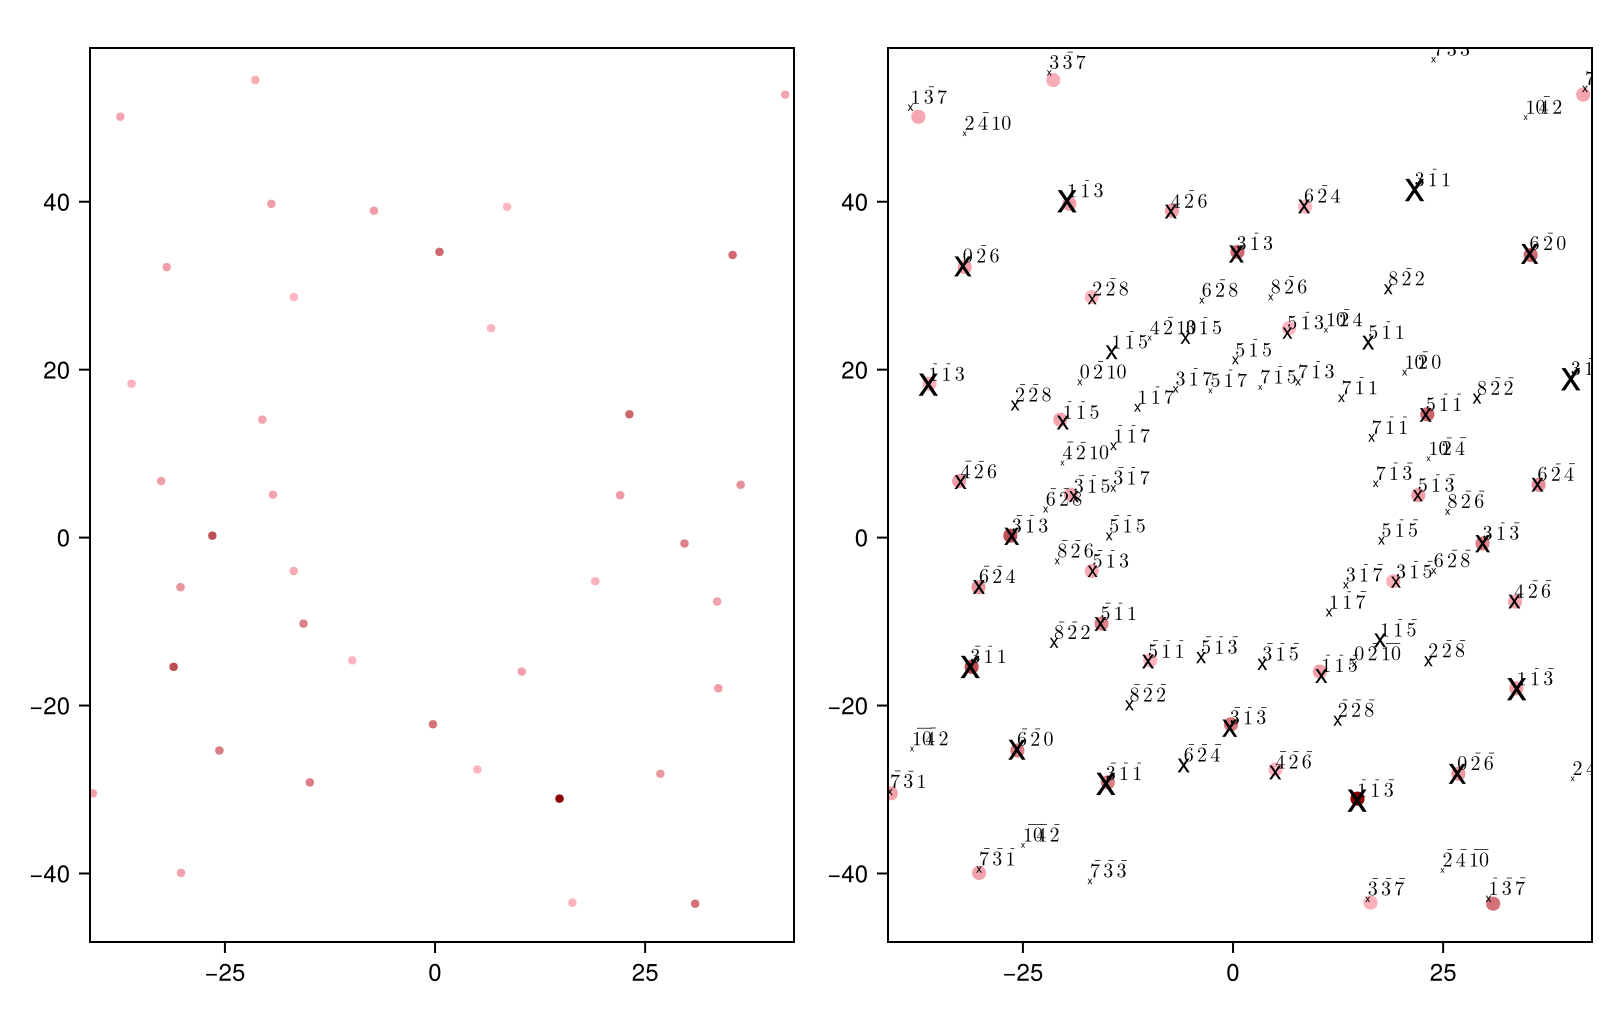

In [8]:
begin # refine grain orientation
    function RefineOrientation(x11, x12, x13, x21, x22, x23, x31, x32, x33, gc1, gc2, gc3)
        return RefineOrientationInner(x11, x12, x13, x21, x22, x23, x31, x32, x33, gc1, gc2, gc3, HKLRef, LaueXYZ, Para)
    end
    function RefineOrientationInner(x11, x12, x13, x21, x22, x23, x31, x32, x33, gc1, gc2, gc3, HKLRef, LaueXYZ, Para)
        IncidentBeam = [gc1,gc2,gc3]-Para.Exp_SourceXYZ
        IncidentBeam = IncidentBeam./norm(IncidentBeam)
        rot = [x11 x12 x13; x21 x22 x23; x31 x32 x33]
        SumDistance = 0.
        for i in 1:size(HKLRef, 1)
            DiffVect = HKLRef[i,:]
            DiffVect = DiffVect/norm(DiffVect)
            DiffVect = rot*DiffVect
            DiffBeam = IncidentBeam - dot(IncidentBeam, DiffVect)*2DiffVect
            LaueXYZTry = [gc1,gc2,gc3] + DiffBeam/DiffBeam[2]*(Para.Exp_DetectorCenterXYZ[2]-gc2)
            SumDistance = SumDistance + norm(LaueXYZTry-LaueXYZ[i,:])
        end
        return SumDistance
    end
    Euler = read(h5open(Para.Outputdir*"/5-BackwardCal_tobeOpt.h5"))["Euler"]
    HKLRef = read(h5open(Para.Outputdir*"/5-BackwardCal_tobeOpt.h5"))["HKLRef"]
    LaueXYZ = read(h5open(Para.Outputdir*"/5-BackwardCal_tobeOpt.h5"))["LaueXYZ"]
    x0 = RotZXZ(deg2rad(Euler[1]), deg2rad(Euler[2]), deg2rad(Euler[3]))
    x0 = [x0[1,1] x0[1,2] x0[1,3]; x0[2,1] x0[2,2] x0[2,3]; x0[3,1] x0[3,2] x0[3,3]]
    lb = @. x0-0.1; lb[lb.<-1.].=-1.
    ub = @. x0+0.1; ub[ub.> 1.].= 1.
    model = Model(NLopt.Optimizer)
    set_optimizer_attribute(model, "algorithm", :LN_COBYLA)
    @variable(model, lb[1,1] ≤ x11 ≤ ub[1,1], start = x0[1,1])
    @variable(model, lb[1,2] ≤ x12 ≤ ub[1,2], start = x0[1,2])
    @variable(model, lb[1,3] ≤ x13 ≤ ub[1,3], start = x0[1,3])
    @variable(model, lb[2,1] ≤ x21 ≤ ub[2,1], start = x0[2,1])
    @variable(model, lb[2,2] ≤ x22 ≤ ub[2,2], start = x0[2,2])
    @variable(model, lb[2,3] ≤ x23 ≤ ub[2,3], start = x0[2,3])
    @variable(model, lb[3,1] ≤ x31 ≤ ub[3,1], start = x0[3,1])
    @variable(model, lb[3,2] ≤ x32 ≤ ub[3,2], start = x0[3,2])
    @variable(model, lb[3,3] ≤ x33 ≤ ub[3,3], start = x0[3,3])
    @variable(model, -1e-6 ≤ gc1 ≤ 1e-6, start = 0.)
    @variable(model, -1e-6 ≤ gc2 ≤ 1e-6, start = 0.)
    @variable(model, -1e-6 ≤ gc3 ≤ 1e-6, start = 0.)

    register(model, :RefineOrientation, 12, RefineOrientation; autodiff = true)
    @NLobjective(model, Min, RefineOrientation(x11, x12, x13, x21, x22, x23, x31, x32, x33, gc1, gc2, gc3))
    @constraint(model, [x11 x12 x13; x21 x22 x23; x31 x32 x33]*[x11 x12 x13; x21 x22 x23; x31 x32 x33]' .== Matrix{Float64}(I, 3, 3))
    JuMP.optimize!(model)
    if is_solved_and_feasible(model)
        FittedEuler = rad2deg.(Rotations.params(RotZXZ([value(x11) value(x12) value(x13); value(x21) value(x22) value(x23); value(x31) value(x32) value(x33)])))
        GrainCenter = [value(gc1), value(gc2), value(gc3)]
        writedlm(Para.Outputdir*"/6-BackwardCal_FittedGrainEulerCenter.txt", [FittedEuler GrainCenter]')
        display(FittedEuler)
        display(GrainCenter)
        tem = CalculateAverageDistance!([1.,0.,0.], [0.,1.,0.], [0.,0.,1.], HKLRef, LaueXYZ, Para)
        display(mean(tem))
    else
        error("No solution")
    end
    
    fig = Figure(; size = (2Para.Exp_PixelNums[1]/1.2, Para.Exp_PixelNums[2]/1.2), fontsize = 12)
    begin
        ax = Axis(fig[1, 1], aspect = DataAspect(), xgridvisible = false, ygridvisible = false)
		LaueXYZInten = Float32.(readdlm(Para.Outputdir*"/Exp_LaueXYZ_Intensity.txt"))
		scatter!(LaueXYZInten[:,1], LaueXYZInten[:,3], markersize = 6, color = LaueXYZInten[:,4], colormap = (:reds), strokecolor = :black, strokewidth = 0)
		xlims!(ax, Para.Exp_DetectorCenterXYZ[1]-Para.Exp_DetectorSize[1]/2, Para.Exp_DetectorCenterXYZ[1]+Para.Exp_DetectorSize[1]/2)
		ylims!(ax, Para.Exp_DetectorCenterXYZ[3]-Para.Exp_DetectorSize[2]/2, Para.Exp_DetectorCenterXYZ[3]+Para.Exp_DetectorSize[2]/2)
    end
	Para.GrainEuler[1] = FittedEuler[1]
	Para.GrainEuler[2] = FittedEuler[2]
	Para.GrainEuler[3] = FittedEuler[3]
    Para.GrainCenter[1] = GrainCenter[1]
	Para.GrainCenter[2] = GrainCenter[2]
	Para.GrainCenter[3] = GrainCenter[3]
    BaseHKLs = read(h5open(Para.Outputdir*"/BaseHKLF2.h5", "r")["HKL"])
	BaseF2s = read(h5open(Para.Outputdir*"/BaseHKLF2.h5", "r")["F2"])
	HKL, Inten, DiffVect, DiffBeam, LaueXYZ, d_spacing, E = SimulateLaueSpotListCubic(Para, BaseHKLs, BaseF2s)
	if size(LaueXYZ,1)>0
		ax = Axis(fig[1, 2], aspect = DataAspect(), xgridvisible = false, ygridvisible = false)
        LaueXYZInten = Float32.(readdlm(Para.Outputdir*"/Exp_LaueXYZ_Intensity.txt"))
		scatter!(LaueXYZInten[:,1], LaueXYZInten[:,3], marker = :circle, markersize = 10, color = LaueXYZInten[:,4], colormap = (:reds), strokecolor = :black, strokewidth = 0)
		scatter!(LaueXYZ[:,1], LaueXYZ[:,3], marker = 'x', markersize = Inten./100, color = :black)
		LabelIt = true
		for i in 1:size(HKL,1)
			hh, kk, ll = HKL[i,1], HKL[i,2], HKL[i,3]
			if LabelIt
				if hh<0
					hh = abs(hh)
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\overline{%$hh}", fontsize=10)
				else
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"%$hh", fontsize=10)
				end
				if kk<0
					kk = abs(kk)
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{  }\overline{%$kk}", fontsize=10)
				else
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{  }%$kk", fontsize=10)
				end
				if ll<0
					ll = abs(ll)
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{    }\overline{%$ll}", fontsize=10)
				else
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{    }%$ll", fontsize=10)
				end
			end
		end
		xlims!(ax, Para.Exp_DetectorCenterXYZ[1]-Para.Exp_DetectorSize[1]/2, Para.Exp_DetectorCenterXYZ[1]+Para.Exp_DetectorSize[1]/2)
		ylims!(ax, Para.Exp_DetectorCenterXYZ[3]-Para.Exp_DetectorSize[2]/2, Para.Exp_DetectorCenterXYZ[3]+Para.Exp_DetectorSize[2]/2)
	end
	current_figure()
end

0.28381542547173044

3×3 Matrix{Float64}:
  0.00070419  -0.0126773    0.00148274
 -0.00140355  -0.00017395  -0.000519048
  0.00210932  -0.00170889   0.00246867

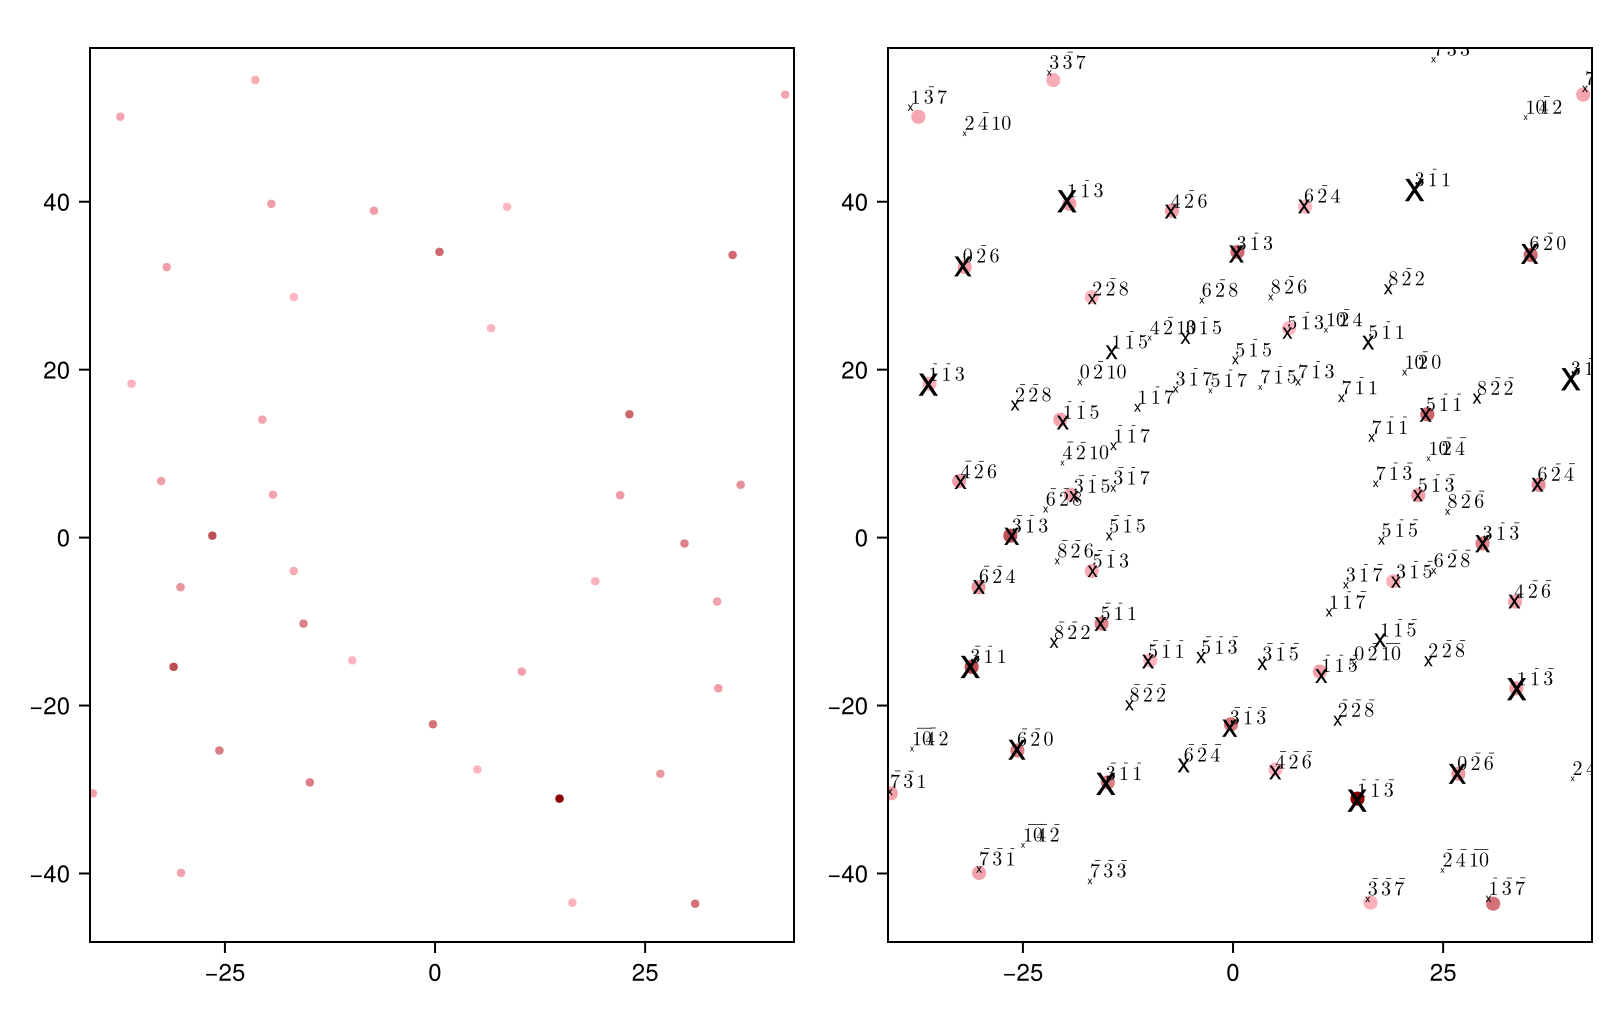

In [19]:
begin # refine grain elastic strain
    function RefineStrain(x1, x2, x3, y1, y2, y3, z1, z2, z3)
        return RefineStrainInner(
            x1, x2, x3, y1, y2, y3, z1, z2, z3, 
            HKLRef::Array{Int8, 2}, LaueXYZ::Union{Array{Float32, 2}, Array{Float64, 2}}, Para::Parameters)
    end
    function RefineStrainInner(
        x1, x2, x3, y1, y2, y3, z1, z2, z3, 
        HKLRef::Array{Int8, 2}, LaueXYZ::Union{Array{Float32, 2}, Array{Float64, 2}}, Para::Parameters
        )
        IncidentBeam = Para.GrainCenter-Para.Exp_SourceXYZ
        IncidentBeam = IncidentBeam./norm(IncidentBeam)
        rot = RotZXZ(deg2rad(Para.GrainEuler[1]), deg2rad(Para.GrainEuler[2]), deg2rad(Para.GrainEuler[3]))
        M = [x1 y1 z1; x2 y2 z2; x3 y3 z3]
        SumDistance = 0.
        for i in 1:size(HKLRef, 1)
            DiffVect = M*HKLRef[i,:]
            DiffVect = DiffVect/norm(DiffVect)
            DiffVect = rot*DiffVect
            DiffBeam = IncidentBeam - dot(IncidentBeam, DiffVect)*2DiffVect
            LaueXYZTry = Para.GrainCenter + DiffBeam/DiffBeam[2]*(Para.Exp_DetectorCenterXYZ[2]-Para.GrainCenter[2])
            SumDistance = SumDistance + norm(LaueXYZTry-LaueXYZ[i,:])
        end
        return SumDistance
    end
    tem = readdlm(Para.Outputdir*"/6-BackwardCal_FittedGrainEulerCenter.txt")
    FittedEuler = tem[1,:]
    GrainCenter = tem[2,:]
    Para.GrainEuler[1] = FittedEuler[1]
	Para.GrainEuler[2] = FittedEuler[2]
	Para.GrainEuler[3] = FittedEuler[3]
    Para.GrainCenter[1] = GrainCenter[1]
	Para.GrainCenter[2] = GrainCenter[2]
	Para.GrainCenter[3] = GrainCenter[3]
    HKLRef = read(h5open(Para.Outputdir*"/5-BackwardCal_tobeOpt.h5"))["HKLRef"]
    LaueXYZ = read(h5open(Para.Outputdir*"/5-BackwardCal_tobeOpt.h5"))["LaueXYZ"]
    xyz0 = [1., 0., 0., 0., 1., 0., 0., 0., 1.]
    lb = @. xyz0-0.02
    ub = @. xyz0+0.02
    model = Model(NLopt.Optimizer)
    set_optimizer_attribute(model, "algorithm", :LN_COBYLA)
    @variable(model, lb[1] ≤ x1 ≤ ub[1], start = xyz0[1])
    @variable(model, lb[2] ≤ x2 ≤ ub[2], start = xyz0[2])
    @variable(model, lb[3] ≤ x3 ≤ ub[3], start = xyz0[3])
    @variable(model, lb[4] ≤ y1 ≤ ub[4], start = xyz0[4])
    @variable(model, lb[5] ≤ y2 ≤ ub[5], start = xyz0[5])
    @variable(model, lb[6] ≤ y3 ≤ ub[6], start = xyz0[6])
    @variable(model, lb[7] ≤ z1 ≤ ub[7], start = xyz0[7])
    @variable(model, lb[8] ≤ z2 ≤ ub[8], start = xyz0[8])
    @variable(model, lb[9] ≤ z3 ≤ ub[9], start = xyz0[9])

    register(model, :RefineStrain, 9, RefineStrain; autodiff = true)
    @NLobjective(model, Min, RefineStrain(x1, x2, x3, y1, y2, y3, z1, z2, z3))
    JuMP.optimize!(model)
    if is_solved_and_feasible(model)
        M = [value(x1) value(y1) value(z1); value(x2) value(y2) value(z2); value(x3) value(y3) value(z3)]
        tem = CalculateAverageDistance!(M[:,1], M[:,2], M[:,3], HKLRef, LaueXYZ, Para)
        display(mean(tem))
        display(M-Matrix{Float64}(I, 3, 3))
    else
        error("No solution")
    end

    fig = Figure(; size = (2Para.Exp_PixelNums[1]/1.2, Para.Exp_PixelNums[2]/1.2), fontsize = 12)
    begin
        ax = Axis(fig[1, 1], aspect = DataAspect(), xgridvisible = false, ygridvisible = false)
		LaueXYZInten = Float32.(readdlm(Para.Outputdir*"/Exp_LaueXYZ_Intensity.txt"))
		scatter!(LaueXYZInten[:,1], LaueXYZInten[:,3], markersize = 6, color = LaueXYZInten[:,4], colormap = (:reds), strokecolor = :black, strokewidth = 0)
		xlims!(ax, Para.Exp_DetectorCenterXYZ[1]-Para.Exp_DetectorSize[1]/2, Para.Exp_DetectorCenterXYZ[1]+Para.Exp_DetectorSize[1]/2)
		ylims!(ax, Para.Exp_DetectorCenterXYZ[3]-Para.Exp_DetectorSize[2]/2, Para.Exp_DetectorCenterXYZ[3]+Para.Exp_DetectorSize[2]/2)
    end
    BaseHKLs = read(h5open(Para.Outputdir*"/BaseHKLF2.h5", "r")["HKL"])
	BaseF2s = read(h5open(Para.Outputdir*"/BaseHKLF2.h5", "r")["F2"])
    HKL, Inten, DiffVect, DiffBeam, LaueXYZ, d_spacing, E = SimulateLaueSpotListCubic(Para, BaseHKLs, BaseF2s)
	if size(LaueXYZ,1)>0
		ax = Axis(fig[1, 2], aspect = DataAspect(), xgridvisible = false, ygridvisible = false)
        LaueXYZInten = Float32.(readdlm(Para.Outputdir*"/Exp_LaueXYZ_Intensity.txt"))
		scatter!(LaueXYZInten[:,1], LaueXYZInten[:,3], marker = :circle, markersize = 10, color = LaueXYZInten[:,4], colormap = (:reds), strokecolor = :black, strokewidth = 0)
		scatter!(LaueXYZ[:,1], LaueXYZ[:,3], marker = 'x', markersize = Inten./100, color = :black)
		LabelIt = true
		for i in 1:size(HKL,1)
			hh, kk, ll = HKL[i,1], HKL[i,2], HKL[i,3]
			if LabelIt
				if hh<0
					hh = abs(hh)
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\overline{%$hh}", fontsize=10)
				else
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"%$hh", fontsize=10)
				end
				if kk<0
					kk = abs(kk)
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{  }\overline{%$kk}", fontsize=10)
				else
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{  }%$kk", fontsize=10)
				end
				if ll<0
					ll = abs(ll)
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{    }\overline{%$ll}", fontsize=10)
				else
					text!(ax, position=(LaueXYZ[i,1], LaueXYZ[i,3]), L"\text{    }%$ll", fontsize=10)
				end
			end
		end
		xlims!(ax, Para.Exp_DetectorCenterXYZ[1]-Para.Exp_DetectorSize[1]/2, Para.Exp_DetectorCenterXYZ[1]+Para.Exp_DetectorSize[1]/2)
		ylims!(ax, Para.Exp_DetectorCenterXYZ[3]-Para.Exp_DetectorSize[2]/2, Para.Exp_DetectorCenterXYZ[3]+Para.Exp_DetectorSize[2]/2)
	end
	current_figure()
end

In [47]:
let 
    display(M)
    display((M'*M-Matrix{Float64}(I, 3, 3))/2)
    display(M*M')
end
#factorize(-Matrix{Float64}(I, 3, 3))

3×3 Matrix{Float64}:
  1.00096     -0.0123586     0.00108636
 -0.0013461    1.00007      -0.000387511
  0.00179625   0.000908622   1.00316

3×3 Matrix{Float64}:
  0.000966567  -0.00685755   0.00144492
 -0.00685755    0.000142341  0.000255264
  0.00144492    0.000255264  0.00316204

3×3 Matrix{Float64}:
  1.00208     -0.0137073    0.00287654
 -0.0137073    1.00013      0.000517529
  0.00287654   0.000517529  1.00633